In [1]:
import nltk
from nltk.corpus import stopwords
import os
import numpy as np
import pandas as pd
import math
import string
import matplotlib.pyplot as plt

In [2]:
def get_tokens(path, stopwords):
    
    token_dict = {}
    all_tokens = []
    text_ngrams = {}
    tags = ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', '.']
    input_substring = string.punctuation.replace('.','').replace('-','') + '0123456789'    
    remove_dict = dict.fromkeys(input_substring, ' ')
    table = str.maketrans(remove_dict)
    stemmer = nltk.stem.porter.PorterStemmer()
    for filename in os.listdir(path):
        file_path = os.path.join(path,filename)
        if(os.path.isfile(file_path)):
            with open(file_path, "r") as file: 
                tokens = []
                tagged_tokens = []                
                for line in file:
                    tokens.extend(line.split(' ')) # tokenize on white space
                tagged_tokens = [x.strip().split('_') for x in tokens if x.strip()!= ""]
                text_ngrams[filename] = []
                text_ngrams[filename].append(list(nltk.bigrams([stemmer.stem(x[0].lower().translate(table)) for x in tagged_tokens])))
                text_ngrams[filename].append(list(nltk.trigrams([stemmer.stem(x[0].lower().translate(table)) for x in tagged_tokens])))
                tokens = [x[0].lower().translate(table) for x in tagged_tokens if x[1] in tags] 
                tokens = [token for token in tokens if token not in stopwords]                
                tokens = [stemmer.stem(token).strip(" -_") for token in tokens]
                tokens = [token for token in tokens if token not in stopwords]
                token_dict[filename] = tokens
                all_tokens.extend(tokens)

    return token_dict, text_ngrams, all_tokens

In [3]:
def preprocess_gold(path):
    gold_dict = {}
    input_substring = string.punctuation.replace('.','').replace('-','') + '0123456789'    
    remove_dict = dict.fromkeys(input_substring, ' ')
    table = str.maketrans(remove_dict)
    stemmer = nltk.stem.porter.PorterStemmer()
    for filename in os.listdir(path):
        if not filename.startswith('.'):
            file_path = os.path.join(path,filename)
            if(os.path.isfile(file_path)):
                with open(file_path, "r") as file:
                    gold_dict[filename] = []
                    for line in file: 
                        line = line.translate(table)
                        gold_dict[filename].append(" ".join([stemmer.stem(x) for x in line.split()])) 
    return gold_dict
    

In [4]:
def create_adj_map(token_list, text_bigrams):
    n = len(token_list)
    token_bigrams = list(nltk.bigrams(token_list))
    adj_map = {}
    if n == 1:
        adj_map = {next(iter(token_list)):None}
        return adj_map
    
    for item in token_bigrams:
        if item in text_bigrams:
            if item[0] in adj_map:
                if item[1] in adj_map[item[0]]:
                    adj_map[item[0]][item[1]] += 1
                else:
                    adj_map[item[0]][item[1]] = 1
            else:
                adj_map[item[0]] = {}
                adj_map[item[0]][item[1]] = 1
                
            if item[1] in adj_map:
                if item[0] in adj_map[item[1]]:
                    adj_map[item[1]][item[0]] += 1
                else:
                    adj_map[item[1]][item[0]] = 1
            else:
                adj_map[item[1]] = {}
                adj_map[item[1]][item[0]] = 1

            adj_map.pop('.', None)
            for key in adj_map:
                adj_map[key].pop('.', None)
            
    return adj_map  

In [5]:
def PageRank(s, alpha, adj_map, iter_count):
    iter_count += 1
    n = len(s)
    p = 1/n
    
    for key in s:
        total = 0.0
        if key in adj_map and adj_map[key]:
            for adj_key in adj_map[key]:
                num = (adj_map[adj_key][key] * s[adj_key])
                deno = 0
                for adj_adj_key in adj_map[adj_key]:
                    deno += adj_map[adj_key][adj_adj_key]
                total += (num/deno)
        s[key] = alpha * total + (1-alpha)*p
    if iter_count == 10:
        return
    else:
        PageRank(s, alpha, adj_map, iter_count)
    return s  

In [6]:
def add_ngrams(a, ngrams):
    for item in ngrams[0]:
        if(item[0] in a and item[1] in a):
            a[item] = a[item[0]] + a[item[1]]
    for item in ngrams[1]:
        if(item[0] in a and item[1] in a and item[2] in a):
            a[item] = a[item[0]] + a[item[1]] + a[item[2]]

In [7]:
def get_keyphrases_pr(token_dict, gold_dict, text_ngrams, alpha):
    pred_list = {}
    for doc in token_dict:
        if doc in gold_dict:
            adj_map = create_adj_map(token_dict[doc], text_ngrams[doc][0])
            vocab = set(token_dict[doc])
            if '.' in vocab:
                vocab.remove('.')
            n = len(vocab)
            init_s = {}
            for word in token_dict[doc]:
                if word!= '.' and word not in init_s:
                    init_s[word] = 1/n
            pr_values = PageRank(init_s, alpha, adj_map, 0)
            add_ngrams(pr_values, text_ngrams[doc])
            sorted_pr_values = sorted(pr_values, key = pr_values.get , reverse = True)
            pred_list[doc] = [" ".join(x) if not isinstance(x, str) else x for x in sorted_pr_values]
            
    return pred_list
    
    

In [8]:
def get_doc_MRR(gold_list, pred_list):
    for i in range(len(pred_list)):
        if pred_list[i] in gold_list:
            return 1/(i+1)
    return 0    

In [9]:
def get_gloabl_MRR(gold_dict, pred_list, k):
    MRR = np.zeros(k)
    for doc in pred_list:
        for i in range(k):
            MRR[i] += get_doc_MRR(gold_dict[doc], pred_list[doc][:i+1])
    return MRR/len(gold_dict) 
    

In [10]:
def build_inverted_index(doc_dict):
    inverted_index = {}            # a dictionary of dictionaries    
    for doc in doc_dict:    
        for word in doc_dict[doc]:
            if word != '.':
                if word in inverted_index:
                    if doc in inverted_index[word]:  #word exists, doc exists
                        inverted_index[word][doc] += 1                                    
                    else:                            #word exists, doc does not exist, 
                        inverted_index[word]['df'] += 1 #increase doc frequency by 1
                        inverted_index[word][doc] = 1                
                else:                                #word does not exist
                    inverted_index[word] = {}         
                    inverted_index[word]['df'] = 1
                    inverted_index[word][doc] = 1            
    return inverted_index

In [11]:
def get_tf_idf(inverted_index, N):
    tf_idf = {}
    for word in inverted_index:
        idf = (math.log10(N / (inverted_index[word]['df'])))
        for doc in inverted_index[word]:
            if doc != 'df':
                if doc in tf_idf:
                    tf_idf[doc][word] = inverted_index[word][doc] * idf
                else:                            
                    tf_idf[doc] = {}
                    tf_idf[doc][word] = inverted_index[word][doc] * idf
    return tf_idf       
            

In [12]:
def get_keyphrases_tf_idf(token_dict):
    pred_list = {}
    inverted_index = build_inverted_index(token_dict)
    tf_idf = get_tf_idf(inverted_index, len(token_dict))
    for doc in tf_idf:
        if doc in gold_dict:        
            add_ngrams(tf_idf[doc], text_ngrams[doc])
            sorted_tf_idf = sorted(tf_idf[doc], key = tf_idf[doc].get , reverse = True)
            pred_list[doc] = [" ".join(x) if not isinstance(x, str) else x for x in sorted_tf_idf] 
    return pred_list
    

In [13]:
def display_results(MRR):
    for i in range(len(MRR)):
        print("K = " + str(i+1) + " MRR = " + str(MRR[i])) 

In [14]:
if __name__ == "__main__":
    
    doc_path = ''
    gold_path = ''
    
    while True:
        doc_path = input("Enter path to the directory where the abstract document(s) are stored:\n")
        if(os.path.isdir(doc_path)):
            break
        else:
            print("Invalid Path or No files exist\n")
    
    while True:
        gold_path = input("Enter path to the directory where the gold standard document(s) are stored:\n")
        if(os.path.isdir(gold_path)):
            break
        else:
            print("Invalid Path or No files exist\n")
              
    print("\nFetching Results...")
    
    stopword_list = []
    with open('stopwords.txt', 'r') as file:
            for line in file:
                line = line.lower()
                stopword_list.append(line.strip())
    stopword_list.extend(list(stopwords.words('english')))                
    stopword_set = set(stopword_list)
    
                
    token_dict, text_ngrams, all_tokens = get_tokens(doc_path, stopword_set)
    gold_dict = preprocess_gold(gold_path)
    
    rem_list = []
    add_list = []
    for key in token_dict:    
        if key not in gold_dict:
            rem_list.append(key)
            if key.replace('.txt', '') in gold_dict:
                add_list.append(key)
    for key in add_list:
        token_dict[key.replace('.txt', '')] = token_dict[key]
        text_ngrams[key.replace('.txt', '')] = text_ngrams[key]

    for key in rem_list:
        token_dict.pop(key,None)
        text_ngrams.pop(key,None)
    
    alpha = 0.85
    k = 10
    
    pred_list_pr = get_keyphrases_pr(token_dict, gold_dict, text_ngrams, alpha)
    MRR = get_gloabl_MRR(gold_dict, pred_list_pr, k)
    
    print("\n***** MRR - PageRank *****\n")
    display_results(MRR)
    
    pred_list_tf_idf = get_keyphrases_tf_idf(token_dict)
    MRR_tf_idf = get_gloabl_MRR(gold_dict, pred_list_tf_idf, k)
    
    print("\n***** MRR - TF-IDF *****\n")
    display_results(MRR_tf_idf)
   

Enter path to the directory where the document(s) are stored:
/home/rashmira/Desktop/IR_HW4/www/www/abstracts
Enter path to the directory where the gold standard document(s) are stored:
/home/rashmira/Desktop/IR_HW4/www/www/gold

Fetching Results...

***** MRR - PageRank *****

K = 1 MRR = 0.04962406015037594
K = 2 MRR = 0.0774436090225564
K = 3 MRR = 0.09624060150375928
K = 4 MRR = 0.11748120300751883
K = 5 MRR = 0.13131578947368416
K = 6 MRR = 0.14221804511278185
K = 7 MRR = 0.14877013963480107
K = 8 MRR = 0.15328141783028978
K = 9 MRR = 0.15737498508175182
K = 10 MRR = 0.16151032342761634

***** MRR - TF-IDF *****

K = 1 MRR = 0.06992481203007518
K = 2 MRR = 0.10563909774436091
K = 3 MRR = 0.12969924812030081
K = 4 MRR = 0.15394736842105283
K = 5 MRR = 0.16642857142857137
K = 6 MRR = 0.1743233082706765
K = 7 MRR = 0.18023093447905447
K = 8 MRR = 0.18652792696025747
K = 9 MRR = 0.19128983172216235
K = 10 MRR = 0.1944477264590043


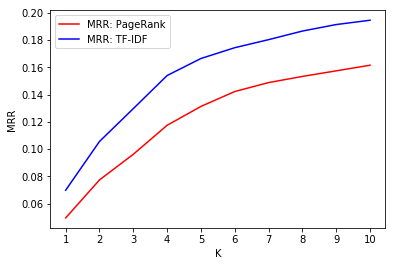

In [15]:
p1 = plt.plot(range(1,11), MRR, 'r')
p2 = plt.plot(range(1,11), MRR_tf_idf, 'b')
plt.legend((p1[0],p2[0]), ('MRR: PageRank', 'MRR: TF-IDF'))
plt.xlabel('K')
plt.ylabel('MRR')
plt.xticks(np.arange(1,11))
plt.show()